In [56]:
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib
import warnings
import scipy.stats as stats 

# Add project root to Python path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Import app modules (use absolute imports, not relative!)
from app.assets import charts, views, preprocessing

# Optional: Reload modules during development
importlib.reload(charts)
importlib.reload(views)
importlib.reload(preprocessing)

# Enable vegafusion for better Altair performance
alt.data_transformers.enable("vegafusion")

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Suppress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')




2025-10-16 18:07:16.693 No runtime found, using MemoryCacheStorageManager
2025-10-16 18:07:16.694 No runtime found, using MemoryCacheStorageManager


📁 Project root: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2
📁 Data directories:
   Raw: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/data/raw
   Processed: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/data/processed


In [57]:
# Load processed data using the data loading function
(df_geo, 
 df_order, 
 df_order_item, 
 df_order_payment, 
 df_order_review, 
 df_product, 
 df_seller, 
 df_customer, 
 df_product_category) = preprocessing.load_processed_data()


## KPI's

In [58]:
# Total sales
df_order_item['price'].sum().astype(int)


np.int64(13591643)

In [59]:
# Total customers

df_customer.shape[0]

99441

In [60]:
# Highest selling city

highest_selling_city = (df_order
    .merge(df_order_item, on='order_id', how='left')
    .merge(df_customer, on='customer_id', how='left')
    .merge(df_geo, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
    .groupby('geolocation_city')
    .agg({'order_id': 'count'})
    .sort_values(by='order_id', ascending=False).head(1)).index[0]

highest_selling_city

'rio de janeiro'

In [61]:
# Highest selling category
(df_order_item.merge(df_product, on='product_id', how='left')
        .groupby('product_category_name')
        .agg({'order_id': 'count'}).sort_values(by='order_id', ascending=False).head(1).index[0])


'bed_bath_table'

## Sales Analysis

In [62]:
# ARPU and total sales by Region and Product Category

sales_by_region = views.get_revenue_ARPU_by_region(df_customer, 
                                                    df_order, 
                                                    df_geo,
                                                    df_order_item, 
                                                    df_product)


bubble_chart = alt.Chart(sales_by_region).mark_circle(opacity=0.7).encode(
    x=alt.X('Sales:Q', title='Total Sales (BRL)'),
    y=alt.Y('ARPU:Q', title='Average Revenue per Order (ARPU)'),
    size=alt.Size('Orders:Q', title='Order Count', scale=alt.Scale(range=[30, 1000])),
    color=alt.Color('geolocation_region:N', title='Region'),
    tooltip=['Product Category', 'geolocation_region', 'Sales', 'ARPU', 'Orders']
).properties(
    title='Sales vs ARPU by Product Category and Region',
    width=800,
    height=500
).interactive()
rule = alt.Chart(sales_by_region).mark_rule(color='red', strokeWidth=2).encode(
    y=alt.Y('mean(ARPU):Q', title='Average Revenue per Order (ARPU)')
)
rule2 = alt.Chart(sales_by_region).mark_rule(color='blue', strokeWidth=2).encode(
    x=alt.X('mean(Sales):Q', title='Total Sales (BRL)')
)


bubble_chart + rule + rule2



alt.LayerChart(...)

**Takeaway:** Increase marketing efforts in products with higher-than average ARPU and sales.

Examples:
- health_beauty, Northeast
- watches_gifts, Northeast
- cool_stuff, Northeast
- auto, Northeast
- watches_gifts, Central-West
- cool_stuff, South

**Next Steps:** 
- Aggregate higher than average products and minimize for find freight price.
- View over time


## View sales over time

In [63]:
# 2016 and 2019 are too low to see any real trends
"""
Above average sales & below average ARPU
"""

# Means
avg_ARPU = sales_by_region["ARPU"].mean()
avg_sales = sales_by_region['Sales'].mean()

# Above average sales, below average ARPU
mask = (sales_by_region['Sales'] > avg_sales) & (sales_by_region['ARPU'] < avg_ARPU)

# Top 10
above_avg = sales_by_region.loc[mask].sort_values(by=['Sales']).head(10)

# Merge order, order_item, product, and above average to grab top sales
merge = (df_order
        .merge(df_order_item)
        .merge(df_product)
        .merge(above_avg, left_on="product_category_name", right_on="Product Category")
        [['ARPU','geolocation_region','price', "product_category_name", "order_purchase_month"]])

#! Move datetime change to preprocessing
merge['order_purchase_month'] = pd.to_datetime(merge['order_purchase_month'])

# Grab only 2017
merge_2017 = merge[merge['order_purchase_month'].dt.year == 2017]

# Group by month and category
merge_2017_agg = merge_2017.groupby(
    ['order_purchase_month', 'product_category_name']
        ).size().reset_index(name='order_count')

chart = alt.Chart(merge_2017_agg).mark_line(point=True).encode(
    x=alt.X('order_purchase_month:T', title='Month'),
    y=alt.Y('order_count:Q', title='Number of Orders'),
    color=alt.Color('product_category_name:N', title='Product Category'),
    tooltip=['order_purchase_month:T', 'product_category_name:N', 'order_count:Q']
).properties(
    title='Top 10 Categories w/ Above Average Sales and Below Average ARPU',
    width=700,
    height=400
).interactive()

chart



alt.Chart(...)

**Observation:** Housewares outperform other categories and have high seasonality.

**Recommendation:** Consider looking into logistical cost-saving measures to increase ARPU during spikes. 

In [64]:
"""
Below average sales & above average ARPU
"""
avg_ARPU = sales_by_region["ARPU"].mean()
avg_sales = sales_by_region['Sales'].mean()
mask = (sales_by_region['Sales'] < avg_sales) & (sales_by_region['ARPU'] > avg_ARPU)
above_avg = sales_by_region.loc[mask].sort_values(by=['ARPU'], ascending=False).head(10)

merge = (df_order
        .merge(df_order_item)
        .merge(df_order_item)
        .merge(df_product)
        .merge(above_avg, left_on="product_category_name", right_on="Product Category")
        [['ARPU','geolocation_region','price', "product_category_name", "order_purchase_month"]])

#! Show multiple regions
merge['order_purchase_month'] = pd.to_datetime(merge['order_purchase_month'])

merge_2017 = merge[merge['order_purchase_month'].dt.year == 2017]

merge_2017_agg = merge_2017.groupby(
    ['order_purchase_month', 'product_category_name']
).size().reset_index(name='order_count')

chart = alt.Chart(merge_2017_agg).mark_line(point=True).encode(
    x=alt.X('order_purchase_month:T', title='Month'),
    y=alt.Y('order_count:Q', title='Number of Orders'),
    color=alt.Color('product_category_name:N', title='Product Category'),
    tooltip=['order_purchase_month:T', 'product_category_name:N', 'order_count:Q']
).properties(
    title='Categories with Below Average Sales and Above Average ARPU',
    width=700,
    height=400
).interactive()

chart


alt.Chart(...)

**Observation:** Computer sales outperform the rest of the above average ARPU, with high seasonality.

**Recommendation:** Consider increasing marketing efforts in earlier months to boost sales. 

# Review Scores Analysis

Delivery time X Review Score: r: -0.33162812254026086, p-val: 0.00000


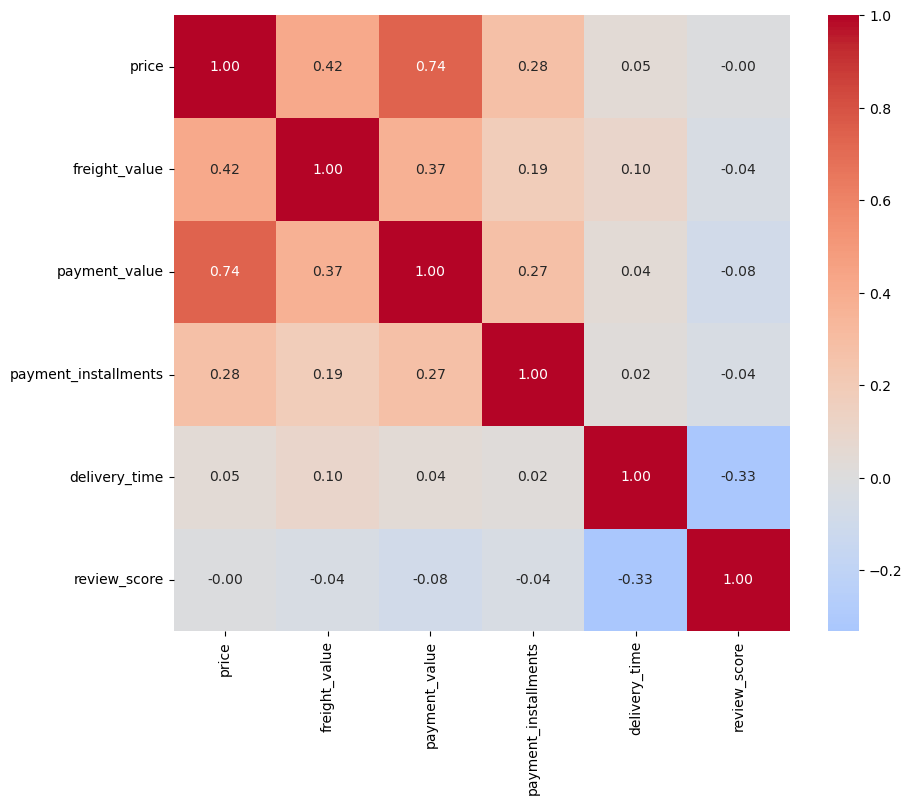

In [68]:
# Merge order, order_item, order_payment, and order_review
orders_merged = (df_order.merge(df_order_item, on='order_id', how='inner')
    .merge(df_order_payment, on='order_id', how='inner')
    .merge(df_order_review, on='order_id', how='left'))
numeric_cols = ['price', 'freight_value', 'payment_value', 
                'payment_installments', 'delivery_time', 'review_score']

corr_data = orders_merged[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, square=True)

mask = orders_merged['review_score'].notnull()
r, p = stats.pearsonr(orders_merged['delivery_time'].loc[mask], orders_merged['review_score'].dropna())
print(f'Delivery time X Review Score: r: {r}, p-val: {p:.5f}')

**Observation:** Delivery time is negatively correlated with review score, with a highly significant p-value. 

**Next Steps:** Determine factors contributing to delivery times

Delivery time X Product Volume
r: 0.048026130969602926, p-val: 0.00000

Delivery time X price
r: 0.02272698734608291, p-val: 0.00000

Delivery time X weight
r: 0.03910835261917702, p-val: 0.00000


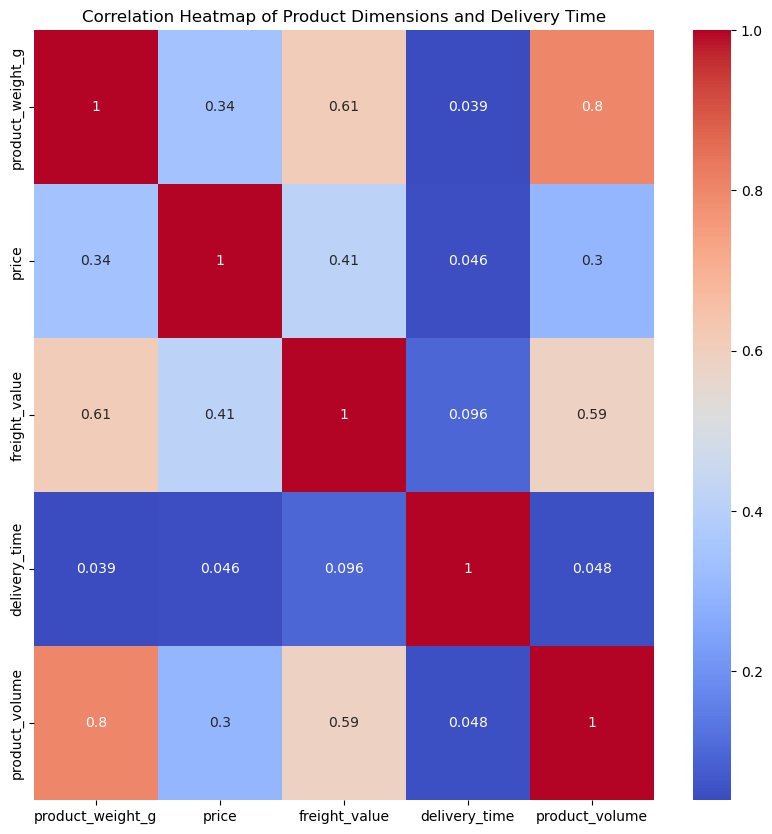

In [ ]:

# Get product description columns
product_desc_cols = ['product_description_lenght','product_weight_g','product_length_cm','product_height_cm','product_width_cm', 'product_id']

# Merge order_item, product, and order
product_delivery_time = df_order_item.merge(df_product[product_desc_cols], on='product_id', how='inner')
product_delivery_time = product_delivery_time.merge(df_order, on='order_id', how='inner')
product_delivery_time['product_volume'] = product_delivery_time['product_length_cm'] * product_delivery_time['product_height_cm'] * product_delivery_time['product_width_cm']

# Get numeric columns for correlation analysis
numeric_cols = ['product_weight_g', 'price','freight_value', 'delivery_time', 'product_volume']

# Get correlation data
corr_data = product_delivery_time[numeric_cols].corr()

# Plot correlation data
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_data, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap of Product Dimensions and Delivery Time')

# Get p-values for correlation analysis
mask = product_delivery_time[['delivery_time', 'product_volume']].notnull().all(axis=1)
x = product_delivery_time.loc[mask, 'delivery_time']
y = product_delivery_time.loc[mask, 'product_volume']

r, p = stats.pearsonr(x, y)
print("Delivery time X Product Volume")
print(f'r: {r}, p-val: {p:.5f}')
print()

mask = product_delivery_time[['delivery_time', 'price']].notnull().all(axis=1)
y= product_delivery_time.loc[mask, 'price']
r, p = stats.pearsonr(x, y[:-1])
print("Delivery time X price")
print(f'r: {r}, p-val: {p:.5f}')
print()

mask = product_delivery_time[['delivery_time', 'product_weight_g']].notnull().all(axis=1)
y = product_delivery_time.loc[mask, 'product_weight_g']
r, p = stats.pearsonr(x, y)
print("Delivery time X weight")
print(f'r: {r}, p-val: {p:.5f}')

**Observation:** These correlations are statistically significant (p < 0.05) 
but practically neglegible. (r < 0.05).

Product dimensions explain less than 0.5% of delivery time variance.
This suggests delivery time is driven by OTHER factors:
- Distance
- Logistics efficiency
- Regional infrastructure

**Next Steps:** Find correlation between distance between buyer and seller and delivery time. If there is a strong correlation, move forward with predictive modeling. 

# Next Steps
- Hypothesis forumalation for significance testing
- Correlation analysis and multivariate analysis